In [2]:
!pip install rasterio

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   --- ------------------------------------ 2.4/25.4 MB 18.9 MB/s eta 0:00:02
   --------- ------------------------------ 5.8/25.4 MB 18.6 MB/s eta 0:00:02
   --------------- ------------------------ 10.0/25.4 MB 19.1 MB/s eta 0:00:01
   ---------------------- ----------------- 14.2/25.4 MB 19.3 MB/s eta 0:00:01
   ---------------------------- ----------- 18.1/25.4 MB 19.2 MB/s eta 0:00:01
   ---------------------------------- ----- 21.8/25.4 MB 19.1 MB/s eta 0:00:01
   ---------------------------------------  25.2/25.4 MB 18.6 MB/s eta 0:00:01
   ---------------------------------------- 25.4/25.4 MB 17.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading ECOSTRESS data...
Loading Sentinel-2 data...
Sentinel-2 data shape: (954, 716, 12)
Detected 12-band Sentinel-2 data. Selecting bands excluding B1, B9, B10...
Using 10 bands for analysis
Final Sentinel-2 data shape: (954, 716, 10)
Resampling ECOSTRESS to Sentinel-2 bands...
Finding closest matches for asphalt...
Finding closest matches for vegetation...
Plotting spectral comparisons...


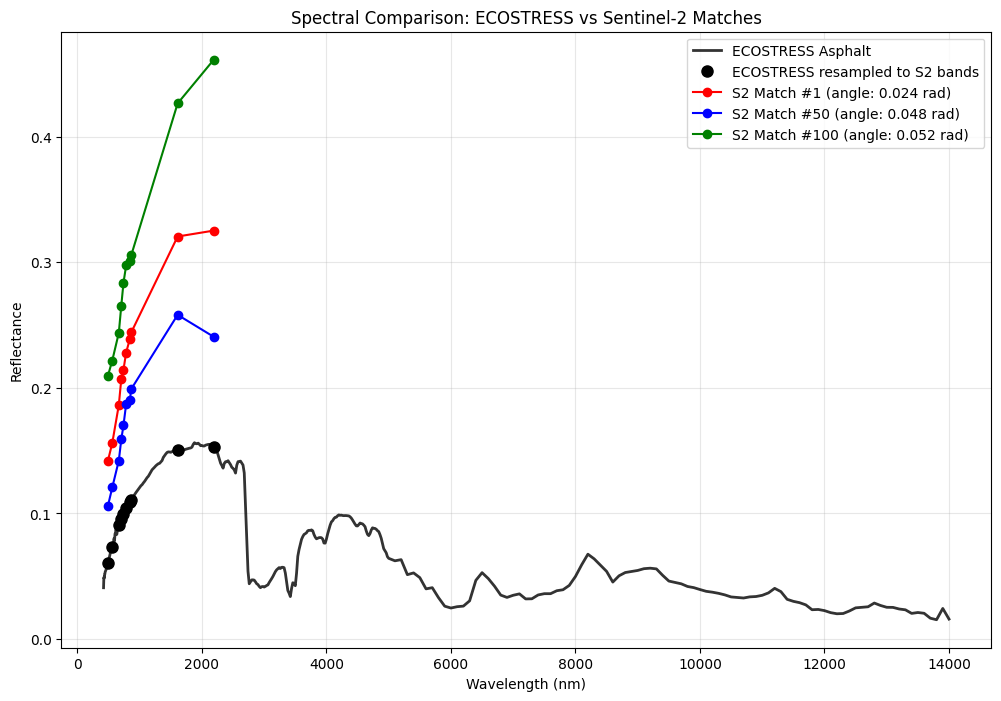

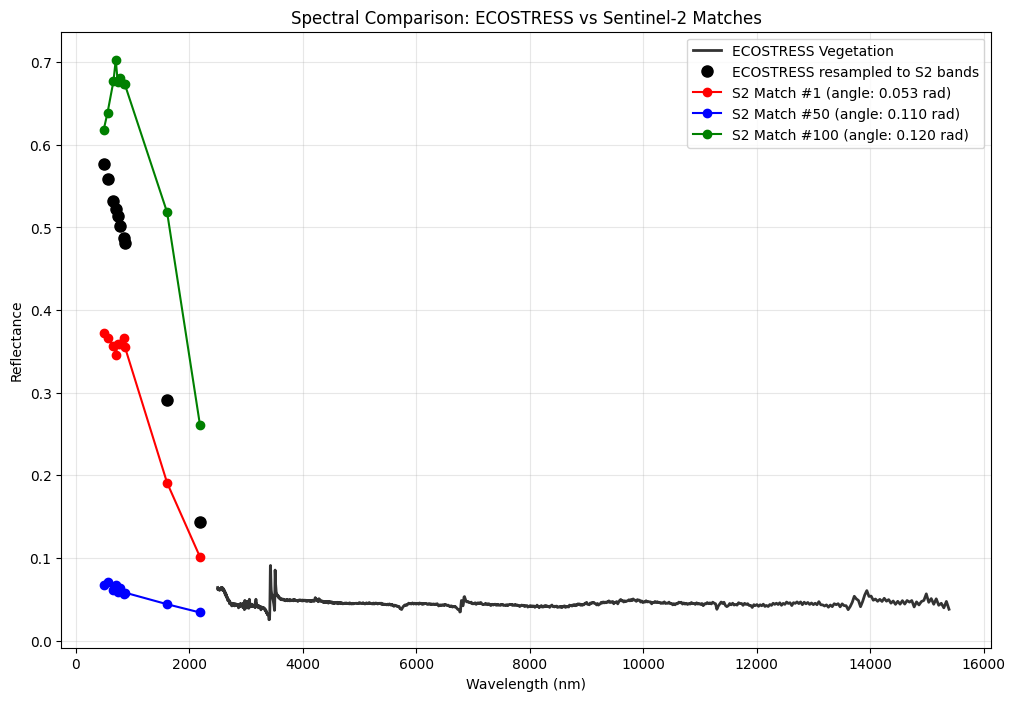


Asphalt Match Analysis:
  Rank 1: Spectral angle = 0.0239 radians (1.37°)
  Rank 50: Spectral angle = 0.0480 radians (2.75°)
  Rank 100: Spectral angle = 0.0521 radians (2.99°)

Vegetation Match Analysis:
  Rank 1: Spectral angle = 0.0532 radians (3.05°)
  Rank 50: Spectral angle = 0.1101 radians (6.31°)
  Rank 100: Spectral angle = 0.1198 radians (6.86°)

Using threshold angle: 0.200 radians (11.5°)
Creating classification map...


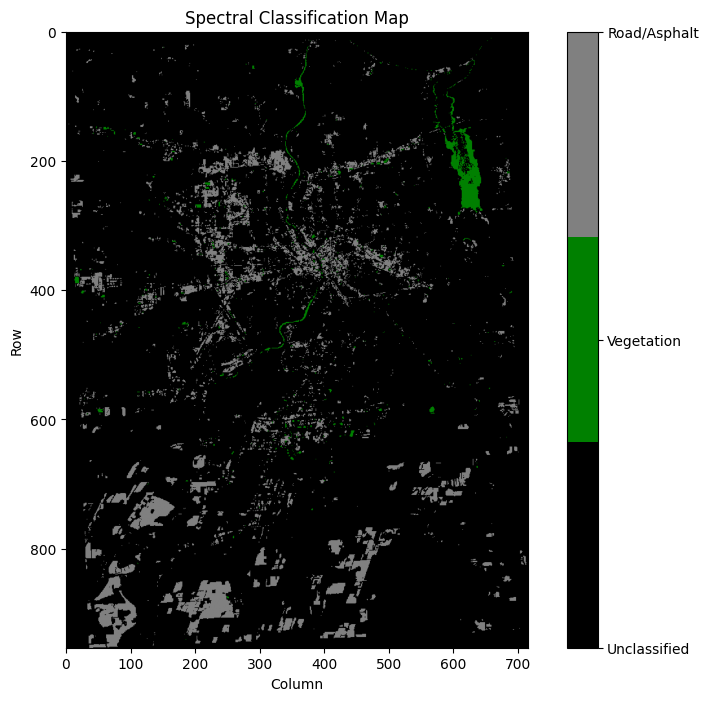

Vegetation: 5915 pixels (0.9%)
Road/Asphalt: 47888 pixels (7.0%)
Unclassified: 629261 pixels (92.1%)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.spatial.distance import cosine
import rasterio
from sklearn.metrics.pairwise import cosine_similarity


SENTINEL2_ALL_BANDS = {
    'B1': 443,   # Coastal aerosol (EXCLUDED)
    'B2': 490,   # Blue
    'B3': 560,   # Green  
    'B4': 665,   # Red
    'B5': 705,   # Red Edge 1
    'B6': 740,   # Red Edge 2
    'B7': 783,   # Red Edge 3
    'B8': 842,   # NIR
    'B8A': 865,  # Narrow NIR
    'B9': 940,   # Water vapor (EXCLUDED)
    'B11': 1610, # SWIR 1
    'B12': 2190  # SWIR 2
}


SENTINEL2_BANDS = {
    'B2': 490,   # Blue
    'B3': 560,   # Green  
    'B4': 665,   # Red
    'B5': 705,   # Red Edge 1
    'B6': 740,   # Red Edge 2
    'B7': 783,   # Red Edge 3
    'B8': 842,   # NIR
    'B8A': 865,  # Narrow NIR
    'B11': 1610, # SWIR 1
    'B12': 2190  # SWIR 2
}

def load_ecostress_data(file_path):
    """Load ECOSTRESS spectral data from text file"""
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
   
    data_start = 0
    for i, line in enumerate(lines):
        if line.strip() and not line.startswith('Name:') and not line.startswith('Type:') and not line.startswith('Additional'):
            try:
               
                parts = line.strip().split()
                if len(parts) == 2:
                    float(parts[0])
                    float(parts[1])
                    data_start = i
                    break
            except ValueError:
                continue
    
    
    wavelengths = []
    reflectances = []
    
    for line in lines[data_start:]:
        line = line.strip()
        if line and not line.startswith('#'):
            try:
                parts = line.split()
                if len(parts) >= 2:
                    wl = float(parts[0]) * 1000  # Convert to nm
                    refl = float(parts[1]) / 100.0  # Convert to 0-1 range
                    wavelengths.append(wl)
                    reflectances.append(refl)
            except ValueError:
                continue
                
    return np.array(wavelengths), np.array(reflectances)

def resample_to_sentinel2(wavelengths, reflectances, s2_bands):
    
    # Create interpolation function
    interp_func = interp1d(wavelengths, reflectances, kind='linear', 
                          bounds_error=False, fill_value='extrapolate')
    
    # Sample at Sentinel-2 band centers
    s2_wavelengths = list(s2_bands.values())
    s2_reflectances = interp_func(s2_wavelengths)
    
    return np.array(s2_wavelengths), s2_reflectances

def spectral_angle_mapper(spectrum1, spectrum2):
   
    
    spectrum1 = np.array(spectrum1).flatten()
    spectrum2 = np.array(spectrum2).flatten()
    
    # Remove any NaN or infinite values
    mask = np.isfinite(spectrum1) & np.isfinite(spectrum2)
    spectrum1 = spectrum1[mask]
    spectrum2 = spectrum2[mask]
    
    if len(spectrum1) == 0 or len(spectrum2) == 0:
        return np.pi/2  
    
    
    cos_sim = np.dot(spectrum1, spectrum2) / (np.linalg.norm(spectrum1) * np.linalg.norm(spectrum2))
    
   
    cos_sim = np.clip(cos_sim, -1, 1)
    
    
    angle = np.arccos(cos_sim)
    
    return angle

def find_closest_matches(sentinel2_data, reference_spectrum, n_matches=100):
    
    height, width, bands = sentinel2_data.shape
    
    
    if len(reference_spectrum) != bands:
        print(f"Warning: Reference spectrum has {len(reference_spectrum)} bands, "
              f"but Sentinel-2 data has {bands} bands")
        if len(reference_spectrum) > bands:
            reference_spectrum = reference_spectrum[:bands]
        else:
            print("Cannot proceed: Reference spectrum has fewer bands than Sentinel-2 data")
            return []
    
    # Reshape Sentinel-2 data to 2D (pixels x bands)
    s2_reshaped = sentinel2_data.reshape(-1, bands)
    
    # Calculate spectral angles for all pixels
    angles = []
    valid_indices = []
    
    for i, pixel_spectrum in enumerate(s2_reshaped):
        # Skip pixels with invalid data (zeros, NaNs)
        if np.any(np.isnan(pixel_spectrum)) or np.all(pixel_spectrum == 0):
            continue
            
        angle = spectral_angle_mapper(pixel_spectrum, reference_spectrum)
        angles.append(angle)
        valid_indices.append(i)
    
    # Sort by spectral angle and get closest matches
    angles = np.array(angles)
    sorted_indices = np.argsort(angles)
    
    closest_matches = []
    for i in range(min(n_matches, len(sorted_indices))):
        idx = valid_indices[sorted_indices[i]]
        row = idx // width
        col = idx % width
        angle = angles[sorted_indices[i]]
        spectrum = s2_reshaped[idx]
        
        closest_matches.append({
            'row': row,
            'col': col,
            'angle': angle,
            'spectrum': spectrum,
            'rank': i + 1
        })
    
    return closest_matches

def plot_spectral_comparison(ecostress_wl, ecostress_refl, s2_wavelengths, 
                           matches, reference_name, ranks_to_plot=[1, 50, 100]):
    
    plt.figure(figsize=(12, 8))
    
    # Plot ECOSTRESS reference spectrum
    plt.plot(ecostress_wl, ecostress_refl, 'k-', linewidth=2, 
             label=f'ECOSTRESS {reference_name}', alpha=0.8)
    
    # Plot resampled ECOSTRESS at Sentinel-2 bands
    ecostress_s2 = resample_to_sentinel2(ecostress_wl, ecostress_refl, SENTINEL2_BANDS)[1]
    plt.plot(s2_wavelengths, ecostress_s2, 'ko', markersize=8, 
             label=f'ECOSTRESS resampled to S2 bands')
    
    # Plot selected Sentinel-2 matches
    colors = ['red', 'blue', 'green']
    for i, rank in enumerate(ranks_to_plot):
        if rank <= len(matches):
            match = matches[rank - 1]
            plt.plot(s2_wavelengths, match['spectrum'], 'o-', 
                    color=colors[i % len(colors)], markersize=6,
                    label=f'S2 Match #{rank} (angle: {match["angle"]:.3f} rad)')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title(f'Spectral Comparison: ECOSTRESS vs Sentinel-2 Matches')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def create_classification_map(sentinel2_data, reference_spectra, threshold_angle, 
                            material_names):
   
    height, width, bands = sentinel2_data.shape
    classification_map = np.zeros((height, width), dtype=int)
    
    for i in range(height):
        for j in range(width):
            pixel_spectrum = sentinel2_data[i, j, :]
            
            # Skip invalid pixels
            if np.any(np.isnan(pixel_spectrum)) or np.all(pixel_spectrum == 0):
                continue
            
            # Find best match among reference spectra
            best_angle = float('inf')
            best_class = 0
            
            for class_idx, ref_spectrum in enumerate(reference_spectra):
                angle = spectral_angle_mapper(pixel_spectrum, ref_spectrum)
                if angle < best_angle and angle < threshold_angle:
                    best_angle = angle
                    best_class = class_idx + 1  # 1-indexed classes
            
            classification_map[i, j] = best_class
    
    return classification_map

def visualize_classification(classification_map, material_names):
    
    plt.figure(figsize=(10, 8))
    
    # Create custom colormap
    colors = ['black', 'green', 'gray']  # background, vegetation, road
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(colors[:len(material_names) + 1])
    
    plt.imshow(classification_map, cmap=cmap, vmin=0, vmax=len(material_names))
    
    # Add colorbar with labels
    cbar = plt.colorbar(ticks=range(len(material_names) + 1))
    labels = ['Unclassified'] + material_names
    cbar.set_ticklabels(labels)
    
    plt.title('Spectral Classification Map')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()


def main_analysis(asphalt_file, vegetation_file, sentinel2_file):
   
    
    print("Loading ECOSTRESS data...")
    # Load ECOSTRESS data
    asphalt_wl, asphalt_refl = load_ecostress_data(asphalt_file)
    vegetation_wl, vegetation_refl = load_ecostress_data(vegetation_file)
    
    print("Loading Sentinel-2 data...")
   
    sentinel2_data = np.load(sentinel2_file)
    
    print(f"Sentinel-2 data shape: {sentinel2_data.shape}")
    
   
    height, width, actual_bands = sentinel2_data.shape
    
    # Create a mapping based on the number of bands in your data
    if actual_bands == 12:
       
        print("Detected 12-band Sentinel-2 data. Selecting bands excluding B1, B9, B10...")
        
        band_indices = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]  # Skip B1(idx 0) and B9(idx 9)
        sentinel2_data = sentinel2_data[:, :, band_indices]
        selected_bands = SENTINEL2_BANDS
    elif actual_bands == 10:
        # Already filtered data
        print("Detected 10-band Sentinel-2 data (pre-filtered).")
        selected_bands = SENTINEL2_BANDS
    elif actual_bands == 13:
        
        print("Detected 12-band Sentinel-2 data. Selecting bands excluding B1, B9, B10...")
       
        band_indices = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12]  # Skip B1(0), B9(9), B10(10), select B11(11)
        sentinel2_data = sentinel2_data[:, :, band_indices]
        selected_bands = SENTINEL2_BANDS
    else:
        print(f"Unexpected number of bands: {actual_bands}. Using first {min(actual_bands, 10)} bands.")
        selected_bands = dict(list(SENTINEL2_BANDS.items())[:min(actual_bands, 10)])
        if actual_bands < 10:
            sentinel2_data = sentinel2_data[:, :, :actual_bands]
    
    print(f"Using {sentinel2_data.shape[2]} bands for analysis")
    print(f"Final Sentinel-2 data shape: {sentinel2_data.shape}")
    
    print("Resampling ECOSTRESS to Sentinel-2 bands...")
    # Resample to Sentinel-2 bands
    s2_wl, asphalt_s2 = resample_to_sentinel2(asphalt_wl, asphalt_refl, selected_bands)
    _, vegetation_s2 = resample_to_sentinel2(vegetation_wl, vegetation_refl, selected_bands)
    
    # Ensure the resampled spectra match the number of bands in the Sentinel-2 data
    if len(asphalt_s2) != sentinel2_data.shape[2]:
        print(f"Adjusting reference spectra to match {sentinel2_data.shape[2]} bands")
        asphalt_s2 = asphalt_s2[:sentinel2_data.shape[2]]
        vegetation_s2 = vegetation_s2[:sentinel2_data.shape[2]]
        s2_wl = s2_wl[:sentinel2_data.shape[2]]
    
    print("Finding closest matches for asphalt...")
    # Find closest matches for asphalt
    asphalt_matches = find_closest_matches(sentinel2_data, asphalt_s2, 100)
    
    print("Finding closest matches for vegetation...")
    # Find closest matches for vegetation
    vegetation_matches = find_closest_matches(sentinel2_data, vegetation_s2, 100)
    
    print("Plotting spectral comparisons...")
    # Plot comparisons
    plot_spectral_comparison(asphalt_wl, asphalt_refl, s2_wl, 
                           asphalt_matches, "Asphalt")
    
    plot_spectral_comparison(vegetation_wl, vegetation_refl, s2_wl, 
                           vegetation_matches, "Vegetation")
    
    # Print analysis of matches
    print("\nAsphalt Match Analysis:")
    for rank in [1, 50, 100]:
        if rank <= len(asphalt_matches):
            match = asphalt_matches[rank - 1]
            print(f"  Rank {rank}: Spectral angle = {match['angle']:.4f} radians ({np.degrees(match['angle']):.2f}°)")
    
    print("\nVegetation Match Analysis:")
    for rank in [1, 50, 100]:
        if rank <= len(vegetation_matches):
            match = vegetation_matches[rank - 1]
            print(f"  Rank {rank}: Spectral angle = {match['angle']:.4f} radians ({np.degrees(match['angle']):.2f}°)")
    
    # Set threshold angle (you can adjust this based on your analysis)
    threshold_angle = 0.2  # radians (~11.5 degrees)
    print(f"\nUsing threshold angle: {threshold_angle:.3f} radians ({np.degrees(threshold_angle):.1f}°)")
    
    print("Creating classification map...")
    # Create classification map
    reference_spectra = [vegetation_s2, asphalt_s2]
    material_names = ['Vegetation', 'Road/Asphalt']
    
    classification_map = create_classification_map(sentinel2_data, reference_spectra, 
                                                 threshold_angle, material_names)
    
    # Visualize results
    visualize_classification(classification_map, material_names)
    
    # Print classification statistics
    total_pixels = classification_map.size
    for i, material in enumerate(material_names):
        count = np.sum(classification_map == i + 1)
        percentage = (count / total_pixels) * 100
        print(f"{material}: {count} pixels ({percentage:.1f}%)")
    
    unclassified = np.sum(classification_map == 0)
    print(f"Unclassified: {unclassified} pixels ({(unclassified/total_pixels)*100:.1f}%)")
    
    return asphalt_matches, vegetation_matches, classification_map


if __name__ == "__main__":
   
    asphalt_file = "manmade.road.pavingasphalt.solid.all.0095uuuasp.jhu.becknic.spectrum.txt"
    vegetation_file = "vegetation.tree.quercus.agrifolia.tir.vh080.ucsb.nicolet.spectrum.txt"
    sentinel2_file = "sentinel2_rochester.npy" 
    
    
    asphalt_matches, vegetation_matches, classification_map = main_analysis(
        asphalt_file, vegetation_file, sentinel2_file
    )

EXPLANATION
Sentinel-2 satellite imagery is compared to reference spectral signatures from the ECOSTRESS spectral library in order to perform spectral classification. No-data is handled by eliminating pixels with values of 0 or NaN from the analysis.  In order to determine the closest spectral matches, the code loads reference spectra for materials such as asphalt and vegetation from ECOSTRESS text files, resamples these high-resolution laboratory spectra to match the band centers of Sentinel-2, and then uses the Spectral Angle Mapper (SAM) algorithm to determine the angular distances between each satellite pixel and the reference spectra.  By allocating pixels to material classes (roads, vegetation, etc.) when their spectral angle falls below a certain threshold, it generates classification maps and displays the outcomes using color-coded maps.